In [1]:
import sys, os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size=128
epochs=10
no_cuda=False 
log_interval=100

cuda = not no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, 1, 1)
        self.fc1 = nn.Linear(784*12, 512)
        self.fc21 = nn.Linear(512, 2)
        self.fc22 = nn.Linear(512, 2)
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784*12)
        self.convtrans1 = nn.ConvTranspose2d(12, 1, 3, 1, 1)
        
    def encode(self, x): 
        x = F.relu(self.conv1(x)) 
        h1 = F.relu(self.fc1(x.view(-1, 12*28*28)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.convtrans1(h4.view(-1, 12, 28, 28)))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1, 28, 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE_loss_func = nn.BCELoss(reduction='sum') 
    BCE = BCE_loss_func(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
#         print(recon_batch.shape, data.shape)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/conv_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/conv_sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 139.982315
Train Epoch: 1 [12800/60000 (21%)]	Loss: 144.606552
Train Epoch: 1 [25600/60000 (43%)]	Loss: 142.455887
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.056000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 140.803207
====> Epoch: 1 Average loss: 141.2589
====> Test set loss: 145.6094
Train Epoch: 2 [0/60000 (0%)]	Loss: 130.808411
Train Epoch: 2 [12800/60000 (21%)]	Loss: 140.891037
Train Epoch: 2 [25600/60000 (43%)]	Loss: 145.148819
Train Epoch: 2 [38400/60000 (64%)]	Loss: 140.331985
Train Epoch: 2 [51200/60000 (85%)]	Loss: 144.988388
====> Epoch: 2 Average loss: 141.0441
====> Test set loss: 145.4564
Train Epoch: 3 [0/60000 (0%)]	Loss: 141.630936
Train Epoch: 3 [12800/60000 (21%)]	Loss: 144.051163
Train Epoch: 3 [25600/60000 (43%)]	Loss: 144.773529
Train Epoch: 3 [38400/60000 (64%)]	Loss: 146.278656
Train Epoch: 3 [51200/60000 (85%)]	Loss: 142.850983
====> Epoch: 3 Average loss: 140.7690
====> Test set loss: 145.6204
Train Epoch: 4 [0/60000 (0%)]	L

In [13]:
with torch.no_grad(): 
    train_all = train_loader.dataset.train_data.reshape(-1, 1, 28, 28).float().to(device)
    print(train_all.shape)
    encoded_mu, encoded_logvar = model.encode(train_all) 
    encoded_latent = model.reparameterize(encoded_mu, encoded_logvar) 
    decoded = model(train_all)

torch.Size([60000, 1, 28, 28])


In [14]:
import matplotlib.pyplot as plt 

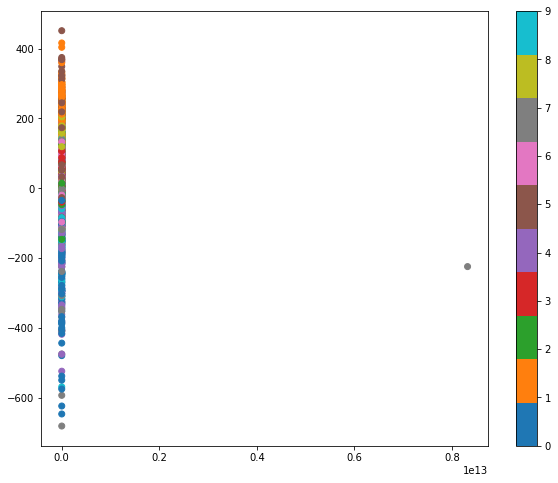

In [15]:
plt.figure(figsize=(10,8))
plt.scatter(encoded_latent.cpu()[:2000,0], encoded_latent.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10')
plt.colorbar()

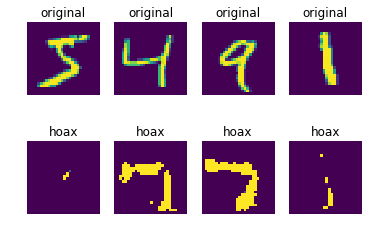

In [11]:
import matplotlib.pyplot as plt 
import numpy as np
n_cols = 4
fig, ax = plt.subplots(nrows=2, ncols=n_cols) 

for i in range(n_cols): 
    ax[0,i].imshow(np.squeeze(train_all.cpu())[2*i].reshape(28,28)) 
    ax[0,i].set_title('original')
    ax[1,i].imshow(np.squeeze(decoded[0].cpu().numpy())[2*i].reshape(28,28)) 
    ax[1,i].set_title('hoax')
    ax[0,i].axis('off') 
    ax[1,i].axis('off')
plt.show()